In [35]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.arima import ARIMASummary
from statsforecast.models import AutoARIMA, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, SeasonalNaive

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

In [2]:
plt.rcParams['figure.figsize'] = (9,6)

## SARIMA

In [12]:
url = "https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesForecastingInPython/refs/heads/master/data/monthly-milk-production-pounds.csv"
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month']+'-01')+pd.offsets.MonthEnd(1)
df['Month'] = df['Month'].dt.date
df = df.rename(columns={"Month": "Date", "Monthly milk production (pounds per cow)": "y"})
df.insert(0, 'unique_id', 1)

df.head()

,unique_id,Date,y
0,1,1962-01-31,589
1,1,1962-02-28,561
2,1,1962-03-31,640
3,1,1962-04-30,656
4,1,1962-05-31,727


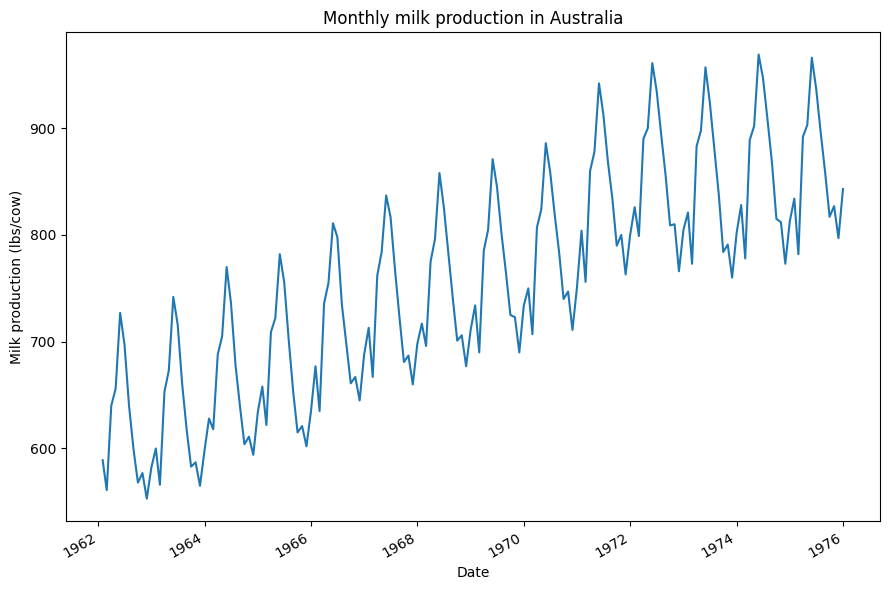

In [13]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

In [29]:
arima = AutoARIMA(max_p=12,
                  max_q=12,
                  seasonal=False, 
                  alias='ARIMA')

sarima = AutoARIMA(max_p=5,
                   max_q=5,
                   max_d=2,
                   max_P=2,
                   max_Q=2,
                   max_D=1,
                   start_p=0,
                   start_q=0,
                   start_P=0,
                   start_Q=0,
                   season_length=12,
                   alias='SARIMA')

sf = StatsForecast(models=[arima, sarima], freq='M')
cv_df = sf.cross_validation(h=12, 
                            df=df, 
                            n_windows=5, 
                            step_size=12, 
                            level=[80], 
                            time_col='Date')

cv_df.head()

,unique_id,Date,cutoff,y,ARIMA,ARIMA-lo-80,ARIMA-hi-80,SARIMA,SARIMA-lo-80,SARIMA-hi-80
0,1,1971-01-31,1970-12-31,804.0,756.762,710.110,803.413,771.522,762.487,780.557
1,1,1971-02-28,1970-12-31,756.0,758.440,693.267,823.612,731.579,720.795,742.363
2,1,1971-03-31,1970-12-31,860.0,771.360,688.597,854.124,826.145,813.871,838.419
3,1,1971-04-30,1970-12-31,878.0,764.375,676.405,852.344,844.624,831.033,858.215
4,1,1971-05-31,1970-12-31,942.0,766.522,678.233,854.812,906.633,891.852,921.414


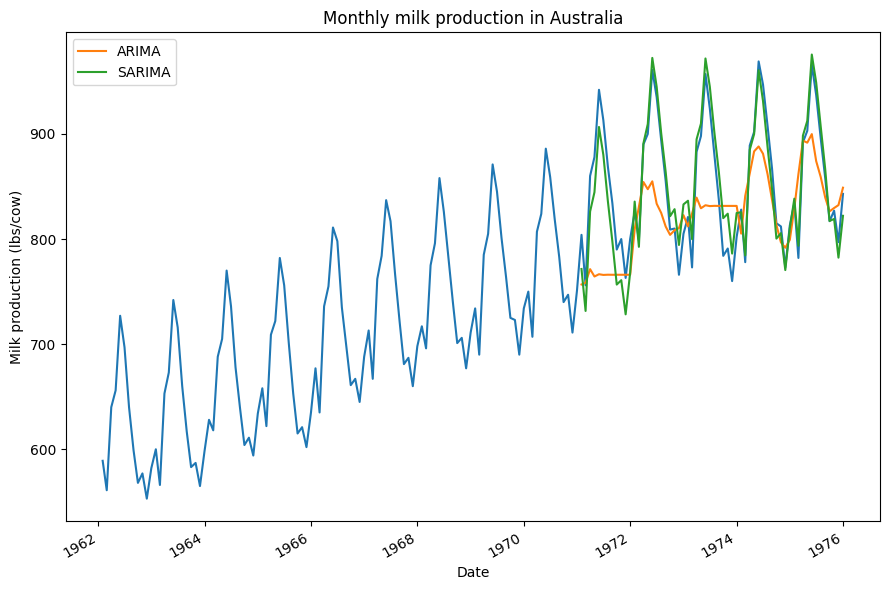

In [30]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.plot(cv_df['Date'], cv_df['ARIMA'], label='ARIMA')
ax.plot(cv_df['Date'], cv_df['SARIMA'], label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
avg_evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,ARIMA,SARIMA
0,mae,45.619,17.334
1,smape,0.027,0.010


In [34]:
sf = StatsForecast(models=[arima, sarima], freq='M')
sf.fit(df=df,time_col='Date')

print(ARIMASummary(sf.fitted_[0, 0].model_))
print(ARIMASummary(sf.fitted_[0, 1].model_))

ARIMA(4,1,2)                   
ARIMA(1,1,0)(0,1,1)[12]                   


## SARIMAX

In [6]:
url = "https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingUsingFoundationModels/refs/heads/main/data/walmart_sales_small.csv"

df = pd.read_csv(url, parse_dates=["Date"])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1.644e+06,0,42.31,2.572,211.096,8.106
1,1,2010-02-12,1.642e+06,1,38.51,2.548,211.242,8.106
2,1,2010-02-19,1.612e+06,0,39.93,2.514,211.289,8.106
3,1,2010-02-26,1.410e+06,0,46.63,2.561,211.320,8.106
4,1,2010-03-05,1.555e+06,0,46.50,2.625,211.350,8.106


In [7]:
df = df[['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag']]
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag
0,1,2010-02-05,1.644e+06,0
1,1,2010-02-12,1.642e+06,1
2,1,2010-02-19,1.612e+06,0
3,1,2010-02-26,1.410e+06,0
4,1,2010-03-05,1.555e+06,0


In [10]:
sarimax = AutoARIMA(max_p=5,
                    max_q=5,
                    max_d=2,
                    max_P=2,
                    max_Q=2,
                    max_D=1,
                    start_p=1,
                    start_q=1,
                    start_P=0,
                    start_Q=0,
                    season_length=1)

sf = StatsForecast(models=[sarimax], freq='W')
cv_df = sf.cross_validation(h=8, 
                            df=df, 
                            n_windows=10, 
                            step_size=8, 
                            level=[80], 
                            time_col='Date', 
                            id_col='Store', 
                            target_col='Weekly_Sales')

cv_df.head()

,Store,Date,cutoff,Weekly_Sales,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,1,2011-04-22,2011-04-15,1.565e+06,1.536e+06,1.327e+06,1.745e+06
1,1,2011-04-29,2011-04-15,1.455e+06,1.535e+06,1.319e+06,1.751e+06
2,1,2011-05-06,2011-04-15,1.629e+06,1.535e+06,1.319e+06,1.751e+06
3,1,2011-05-13,2011-04-15,1.605e+06,1.535e+06,1.319e+06,1.751e+06
4,1,2011-05-20,2011-04-15,1.428e+06,1.535e+06,1.319e+06,1.751e+06


In [11]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='Weekly_Sales', id_col='Store')
avg_evaluation = evaluation.drop(['Store'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,AutoARIMA
0,mae,95323.633
1,smape,0.031


In [3]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

uids = Y_df['unique_id'].unique()[:8] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24) #Select last 7 days of data to make example faster

Y_df.head()

,unique_id,ds,y
580,H1,581,587.0
581,H1,582,537.0
582,H1,583,492.0
583,H1,584,464.0
584,H1,585,443.0


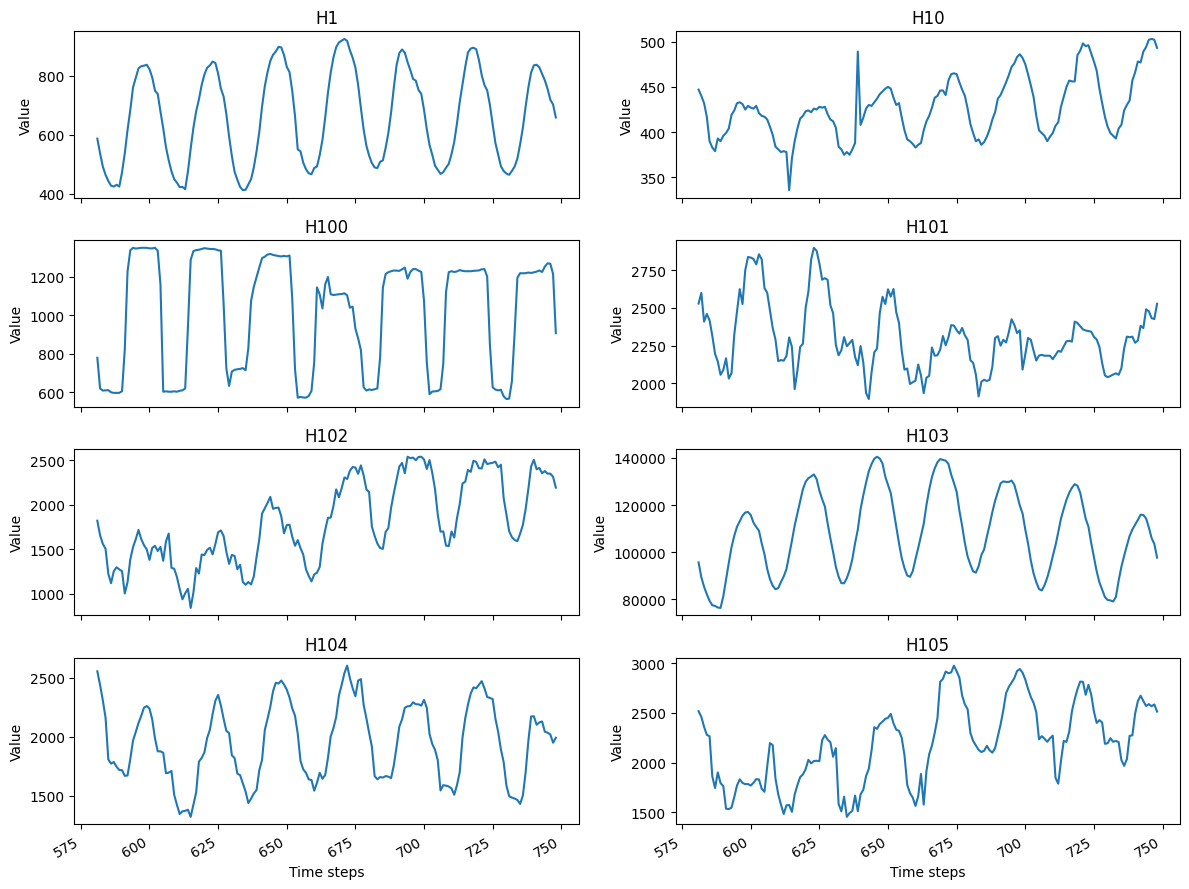

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    uid = uids[i]
    plot_df = Y_df[Y_df['unique_id'] == uid]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.set_title(f'{uid}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

## Exponential smoothing
### Simple exponential smoothing

In [38]:
h = 24

seasonal_naive = SeasonalNaive(season_length=24)
ses = SimpleExponentialSmoothingOptimized(alias='SES')

sf = StatsForecast(models=[seasonal_naive, ses], freq=1)

cv_df = sf.cross_validation(h=h,
                            df=Y_df,
                            n_windows=3,
                            step_size=h)

In [39]:
cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,SES
0,H1,677,676,691.0,664.0,769.603
1,H1,678,676,618.0,550.0,769.603
2,H1,679,676,563.0,544.0,769.603
3,H1,680,676,529.0,505.0,769.603
4,H1,681,676,504.0,483.0,769.603


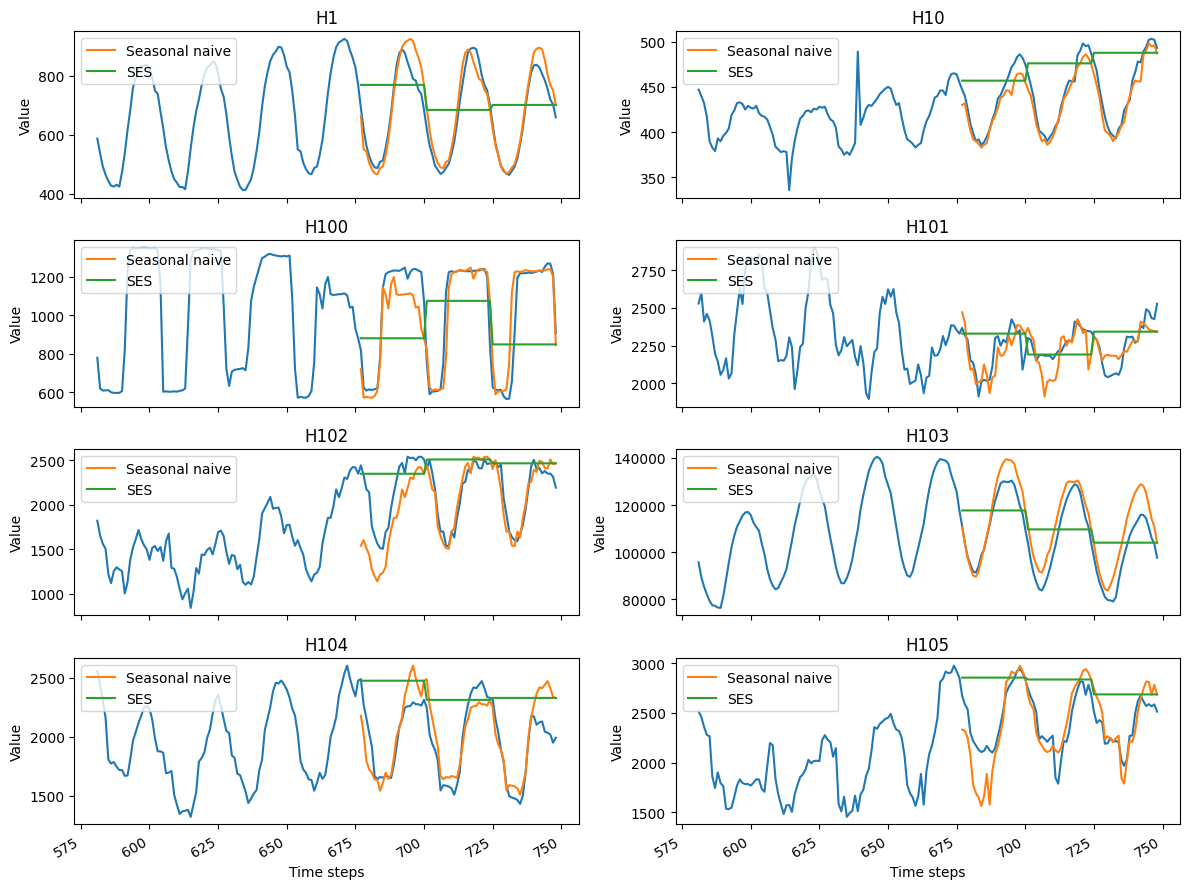

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    uid = uids[i]
    plot_df = Y_df[Y_df['unique_id'] == uid]
    preds_df = cv_df[cv_df['unique_id'] == uid]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.plot(preds_df['ds'], preds_df['SeasonalNaive'], label='Seasonal naive')
    ax.plot(preds_df['ds'], preds_df['SES'], label='SES')
    ax.set_title(f'{uid}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### Double exponential smoothing

In [49]:
des = Holt(season_length=24)

sf = StatsForecast(models=[seasonal_naive, ses, des], freq=1)

cv_df = sf.cross_validation(h=h,
                            df=Y_df,
                            n_windows=3,
                            step_size=h)

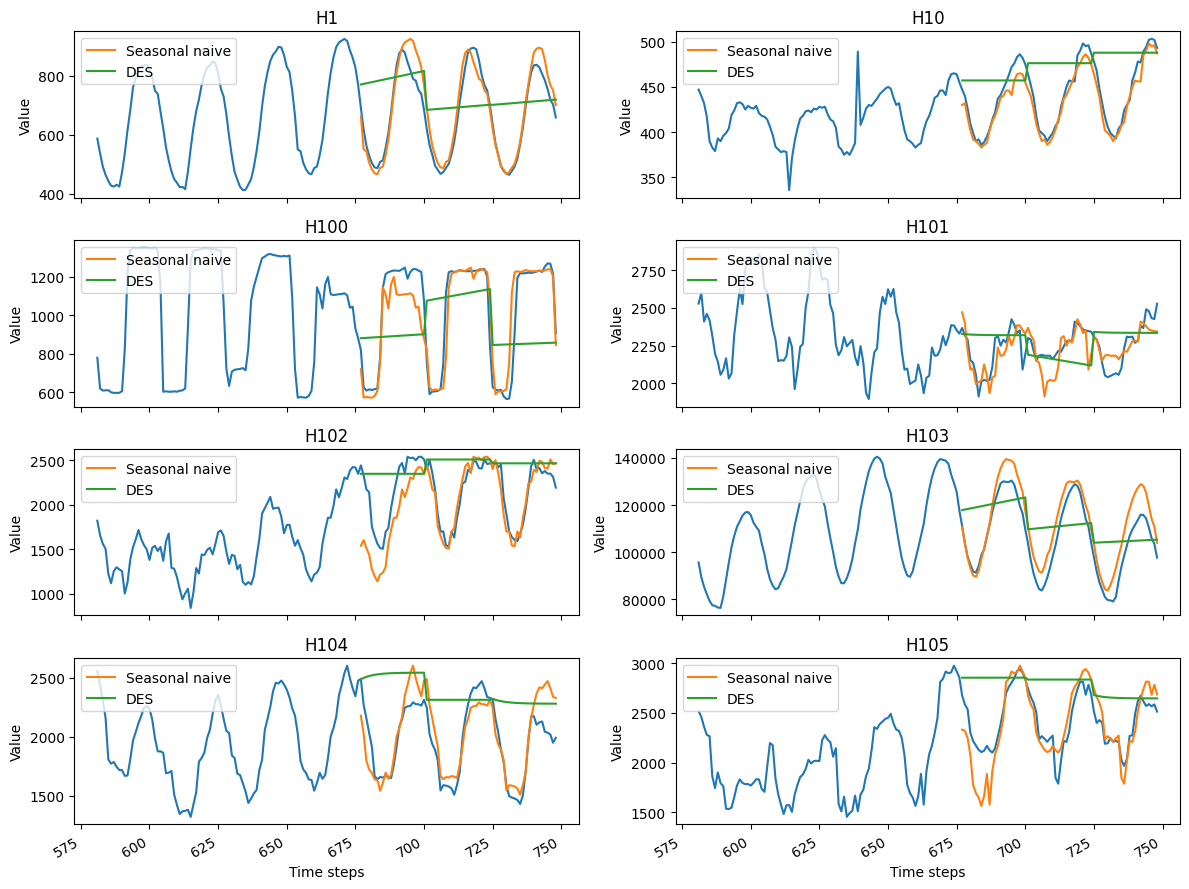

In [51]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    uid = uids[i]
    plot_df = Y_df[Y_df['unique_id'] == uid]
    preds_df = cv_df[cv_df['unique_id'] == uid]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.plot(preds_df['ds'], preds_df['SeasonalNaive'], label='Seasonal naive')
    ax.plot(preds_df['ds'], preds_df['Holt'], label='DES')
    ax.set_title(f'{uid}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### Triple exponential smoothing

In [53]:
tes = HoltWinters(season_length=24)

sf = StatsForecast(models=[seasonal_naive, ses, des, tes], freq=1)

cv_df = sf.cross_validation(h=h,
                            df=Y_df,
                            n_windows=3,
                            step_size=h)

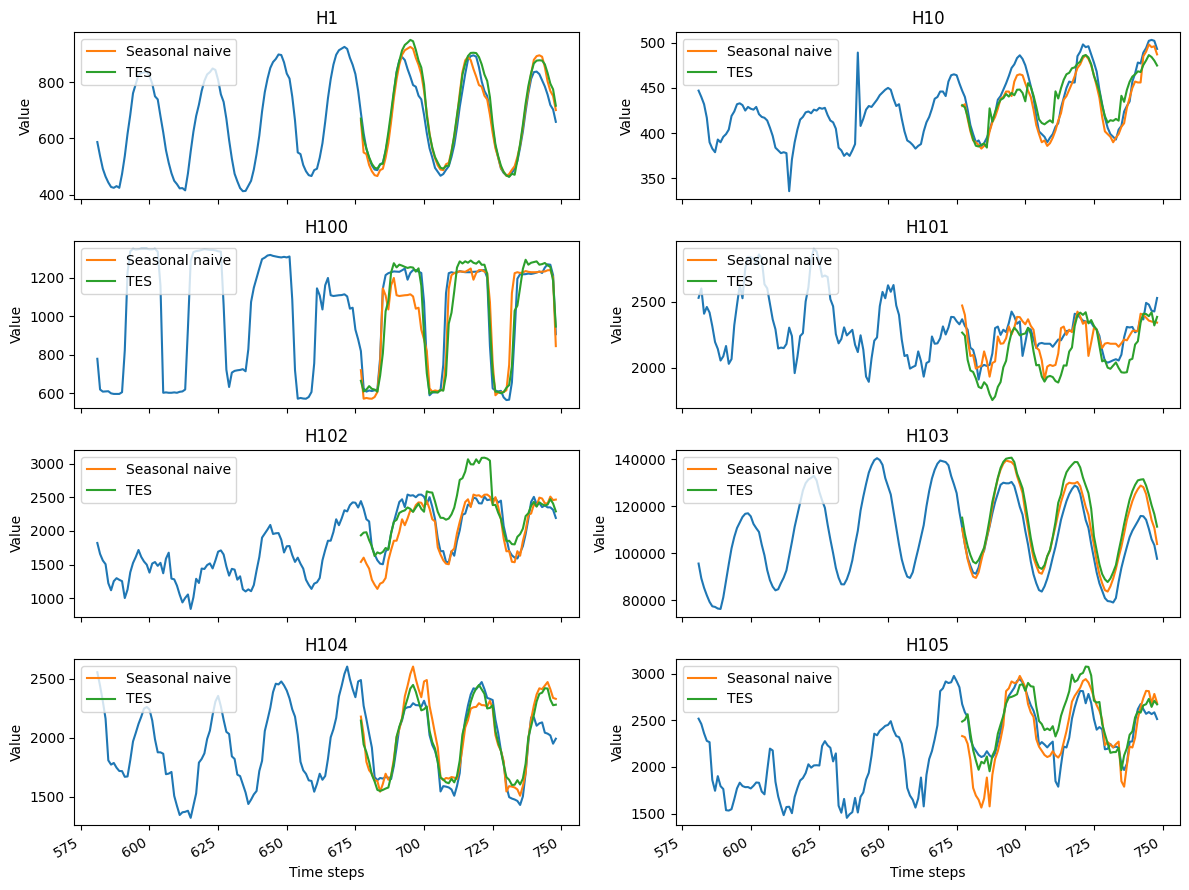

In [54]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    uid = uids[i]
    plot_df = Y_df[Y_df['unique_id'] == uid]
    preds_df = cv_df[cv_df['unique_id'] == uid]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.plot(preds_df['ds'], preds_df['SeasonalNaive'], label='Seasonal naive')
    ax.plot(preds_df['ds'], preds_df['HoltWinters'], label='TES')
    ax.set_title(f'{uid}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [55]:
eval_df = cv_df.drop(['ds', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
avg_evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,SeasonalNaive,SES,Holt,HoltWinters
0,mae,912.858,1777.889,1748.835,1364.443
1,smape,0.030,0.079,0.079,0.034
